# Regression and Other Stories: Simple regression

Linear regression with a single predictor. See Chapters 6 and 7 in Regression and Other Stories.

----

### Load packages

In [1]:
using StatsPlots, Turing, MCMCChains, Random, Distributions
using LaTeXStrings

## Fitting a regression using a data frame in Julia

### Simulate fake data

In [2]:
x = 1:20
n = length(x)
a = 0.2
b = 0.3
sigma = 0.5

# set the random seed to get reproducible results
# change the seed to experiment with variation due to random noise

Random.seed!(2141)
y = a .+ b .* x + rand(Normal(0,sigma), n);

### Linear regression model

In [3]:
@model function linear_reg(x, y)
    
    σ ~ truncated(Normal(0,2.5), 0, Inf)
    
    # Linear
    α ~ Normal(0, 2.5)
    β ~ Normal(0, 2.5)
    
    μ = α .+ x * β
    y ~ MvNormal(μ, σ)
end;

In [4]:
model_1 = linear_reg(x, y)
chain_1 = sample(model_1, NUTS(), 4000)
summarystats(chain_1)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.1213    0.3336     0.0053    0.0082   1372.9834    1.0006    ⋯
           β    0.3041    0.0278     0.0004    0.0006   1396.3491    1.0003    ⋯
           σ    0.7019    0.1271     0.0020    0.0026   1911.0537    1.0000    ⋯
                                                                1 column omitted


### Plot for the book

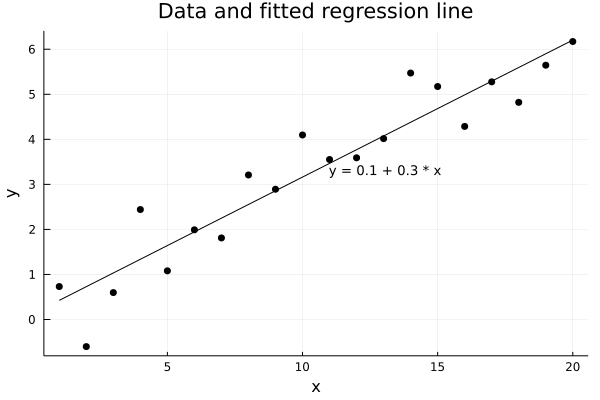

In [5]:
scatter(
    x,y,
    title="Data and fitted regression line",
    xlabel="x", ylabel="y",
    color=:black,
    legend=false
)

coefs = get(chain_1, [:α, :β])
a_hat = mean(coefs.α)
b_hat = mean(coefs.β)

plot!(
    x,
    x-> a_hat + b_hat * x,
    color=:black
)
annotate!(
    mean(x), a_hat + b_hat * mean(x),
    text(
        string("   y = ", round(a_hat, digits=1),
            " + ", round(b_hat, digits=1), " * x"
            ), 
        :left, 9
    )
)

## Formulating comparisons as regression models

### Simulate fake data

In [6]:
n_0 = 200
y_0 = rand(Normal(2.0, 5.0), n_0)
round.(y_0,digits=1)

200-element Vector{Float64}:
  8.6
 -7.8
 -0.4
  3.0
  7.1
  5.9
 10.1
  8.6
 12.7
  4.7
  6.7
  5.9
  6.3
  ⋮
 -2.4
 -2.1
  6.5
  1.5
  6.5
  8.7
  8.7
 -0.2
  0.5
  2.7
 10.5
  6.7

In [7]:
round(mean(y_0), digits=2)

2.12

In [8]:
round(std(y_0) / sqrt(n_0), digits=2)

0.34

### Estimating the mean is the same as regressing on a constant term

(the header for this is very `stan_glm` oriented. In Turing, we're going to define a model with just an outcome normal distribution)

In [9]:
@model function mean_est(y)
    
    σ ~ truncated(Normal(0,10), 0, Inf)
    μ ~ Normal(0, 10)
    y ~ Normal(μ, σ)
end;

In [10]:
model_2 = mean_est(y_0)
chain_2 = sample(model_2, NUTS(), 4000)
summarystats(chain_2)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           μ    2.1154    0.3385     0.0054    0.0051   4350.1967    0.9998    ⋯
           σ    4.8592    0.2467     0.0039    0.0034   4176.6874    0.9998    ⋯
                                                                1 column omitted


### Simulate fake data

In [11]:
n_1 = 300
y_1 = rand(Normal(8, 5), n_1)
diff = mean(y_1) - mean(y_0)
se_0 = std(y_0) / sqrt(n_0)
se_1 = std(y_1) / sqrt(n_1)
se = sqrt(se_0^2 + se_1^2)
println(diff)

5.932361511842256


In [12]:
println(se)

0.44953376591415184


### Estimating a difference is the same as regressing on an indicator variable

In [13]:
n  = n_0 + n_1
y = vcat(y_0, y_1)
x = vcat( zeros(n_0), ones(n_1));

In [14]:
model_3 = linear_reg(x, y)
chain_3 = sample(model_3, NUTS(), 4000)
summarystats(chain_3)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    2.1879    0.3391     0.0054    0.0073   1847.2592    1.0008    ⋯
           β    5.7894    0.4420     0.0070    0.0091   1881.1210    1.0004    ⋯
           σ    4.9644    0.1597     0.0025    0.0028   2584.9110    1.0012    ⋯
                                                                1 column omitted


### Plot for the book

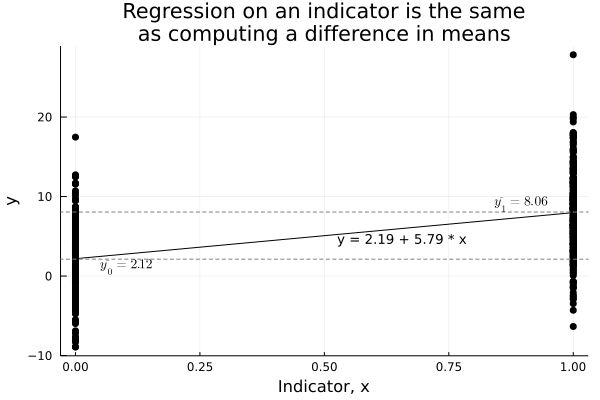

In [15]:
scatter(
    x,y,
    title="Regression on an indicator is the same\nas computing a difference in means",
    xlabel="Indicator, x", ylabel="y",
    color=:black,
    legend=false
)

coefs = get(chain_3, [:α, :β])
a_hat = mean(coefs.α)
b_hat = mean(coefs.β)

plot!(
    x,
    x-> a_hat + b_hat * x,
    color=:black
)
annotate!(
    0.5, -1 + a_hat + b_hat * mean(x),
    text(
        string("   y = ", round(a_hat, digits=2),
            " + ", round(b_hat, digits=2), " * x"
            ), 
        :left, 9
    )
)
annotate!(0.05, -1 + mean(y_0),
    text(LaTeXString("\$\\bar{y_0} = $(round(mean(y_0),digits=2)) \$"),
        9, :left
        )
)
annotate!(0.95, 1 + mean(y_1),
    text(LaTeXString("\$\\bar{y_1} = $(round(mean(y_1),digits=2)) \$"),
        9,:right
        )
)


hline!([mean(y_0), mean(y_1)], color=:gray50, linestyle=:dash)

### Repeat with flat priors

stan_glm uses uniform priors when given NULL, as done in the original notebook, so we'll give those to Turing.

In [16]:
@model function mean_est_flat(y)
    
    σ ~ truncated(Uniform(0,1000), 0, Inf)
    μ ~ Uniform(-1000, 1000)
    y ~ Normal(μ, σ)
end;

In [17]:
model_3b = linear_reg(x, y)
chain_3b = sample(model_3b, NUTS(), 4000)
summarystats(chain_3b)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    2.2033    0.3445     0.0054    0.0067   2101.2534    1.0006    ⋯
           β    5.7709    0.4398     0.0070    0.0094   1901.7228    1.0003    ⋯
           σ    4.9676    0.1579     0.0025    0.0032   2381.6334    1.0002    ⋯
                                                                1 column omitted
